In [109]:
import xarray as xr
import xesmf as xe
import numpy as np 
import pathlib as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches

In [110]:
%%bash
cd
cd WPS
pwd

/bsuhome/stanleyakor/WPS


In [111]:
path = '/bsuhome/stanleyakor/WPS/geo_em.d02.nc'

In [112]:
geog = xr.open_dataset("/bsuhome/stanleyakor/WPS/geo_em.d02.nc")


In [113]:
def get_wrf_xy(lat, lon):
    #lat = 38.89
    #lon = -106.95
    xlat = geog.XLAT_M.values[0,:,:]
    xlon = geog.XLONG_M.values[0,:,:]
    dist = np.sqrt((xlat - lat)**2 + (xlon - lon)**2)
    mindist = dist.min()
    ixlat = np.argwhere(dist == mindist)[0][0]
    ixlon = np.argwhere(dist == mindist)[0][1]
    return ixlat, ixlon


In [70]:
# Brian Blaylock
#
# Created: March 2, 2016


import sys,getopt
#from netCDF4 import Dataset  # we dont have this library. use scipy instead
from scipy.io import netcdf
import matplotlib
#matplotlib.use('Agg')		#required for the CRON job. Says, "do not open plot in a window"??
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime, timedelta

from mpl_toolkits.basemap import Basemap, maskoceans
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes

In [171]:
## Custom Terrain ColorMaps by Brian

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Four Different Land Use Categories:
#   LU_MODIS20
#   LU_MODIS21     includes lake category
#   LU_USGS
#   LU_NLCD


## Land Use Colormap
## ! represents categories not in my Utah domain
def LU_MODIS21(): #
    C = np.array([
    [0,.4,0],      #  1 Evergreen Needleleaf Forest
    [0,.4,.2],      #! 2 Evergreen Broadleaf Forest    
    [.2,.8,.2],     #  3 Deciduous Needleleaf Forest
    [.2,.8,.4],     #  4 Deciduous Broadleaf Forest
    [.2,.6,.2],     #  5 Mixed Forests
    [.3,.7,0],      #  6 Closed Shrublands
    [.82,.41,.12],     #  7 Open Shurblands
    [.74,.71,.41],       #  8 Woody Savannas
    [1,.84,.0],     #  9 Savannas
    [0,1,0],        #  10 Grasslands
    [0,1,1],        #! 11 Permanant Wetlands
    [1,1,0],      #  12 Croplands
    [1,0,0],     #  13 Urban and Built-up
    [.7,.9,.3],      #! 14 Cropland/Natual Vegation Mosaic
    [1,1,1],        #! 15 Snow and Ice
    [.914,.914,.7], #  16 Barren or Sparsely Vegetated
    [.5,.7,1],        #  17 Water (like oceans)
    [.86,.08,.23],        #  18 Wooded Tundra
    [.97,.5,.31],        #! 19 Mixed Tundra
    [.91,.59,.48],     #! 20 Barren Tundra
    [0,0,.88]])      #! 21 Lake
    
   
    cm = ListedColormap(C)
    
    labels = ['Evergreen Needleleaf Forest',
              'Evergreen Broadleaf Forest',
              'Deciduous Needleleaf Forest',
              'Deciduous Broadleaf Forest',
              'Mixed Forests',
              'Closed Shrublands',
              'Open Shrublands',
              'Woody Savannas',
              'Savannas',
              'Grasslands',
              'Permanent Wetlands',
              'Croplands',
              'Urban and Built-Up',
              'Cropland/Natural Vegetation Mosaic',
              'Snow and Ice',
              'Barren or Sparsely Vegetated',
              'Water',
              'Wooded Tundra',
              'Mixed Tundra',
              'Barren Tundra',
              'Other']    
    
    return cm, labels

/tmp/ipykernel_15144/2788259199.py:59: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = plt.pcolormesh(x,y,LU_INDEX,cmap=cm,vmax=len(labels)+1,vmin=1)


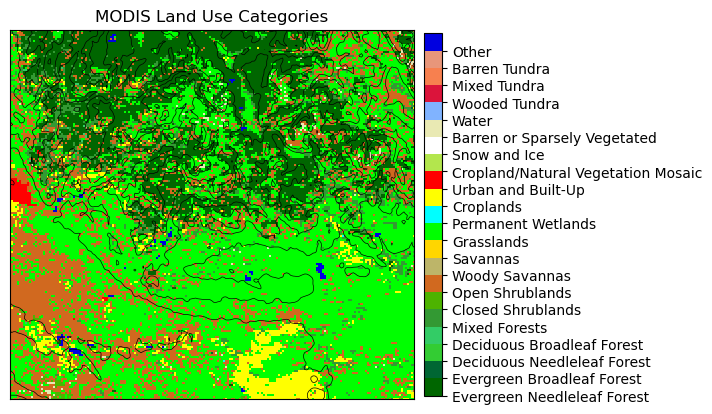

In [181]:
### Get Domain 2 WPS directory
full_file = '/bsuhome/stanleyakor/scratch/thompson/wrfout_d01_2022-12-01_00:00:00'
nc = xr.open_dataset("/bsuhome/stanleyakor/WPS/geo_em.d02.nc")
HGT = nc.variables['HGT_M'][0,:,:].copy()
LU_INDEX = nc.variables['LU_INDEX'][0,:,:].copy()
LAT = nc.variables['XLAT_M'][0].copy()
LON = nc.variables['XLONG_M'][0].copy()

# #nc.close()


## Full_domain
bot_left_lat  = LAT[0][0]+.1
bot_left_lon  = LON[0][0]
top_right_lat = LAT[-1][-1]
top_right_lon = LON[-1][-1]-.15

# """
# # Custom Domain
# domain = get_domain('salt_lake_valley')
# top_right_lat = domain['top_right_lat']+1
# top_right_lon = domain['top_right_lon']+1
# bot_left_lat = domain['bot_left_lat']-1
# bot_left_lon = domain['bot_left_lon']-1
# """

plt.figure(1)
MP = 'lcc'
if MP == 'cyl':
    ## Map in cylindrical projection (data points may apear skewed)
    m = Basemap(resolution='i',area_thresh=10000.,projection='cyl',\
        llcrnrlon=bot_left_lon,llcrnrlat=bot_left_lat,\
        urcrnrlon=top_right_lon,urcrnrlat=top_right_lat,)

if MP == 'lcc':
    ## Map in HRRR projected Coordinates
    m = Basemap(resolution='i',area_thresh=10000.,projection='lcc',\
        lat_0=43.50,lon_0=-114.70,\
        lat_1=43.50, lat_2=43.50,\
        llcrnrlon=bot_left_lon,llcrnrlat=bot_left_lat,\
        urcrnrlon=top_right_lon,urcrnrlat=top_right_lat,)



# This sets the standard grid point structure at full resolution
# Converts WRF lat and long to the maps x an y coordinate
x,y = m(LON,LAT)


m.drawstates(color='k', linewidth=.8)
m.drawcoastlines(color='k')
m.drawcountries(color='k', linewidth=1.25)


cm,labels = LU_MODIS21()



im = plt.pcolormesh(x,y,LU_INDEX,cmap=cm,vmax=len(labels)+1,vmin=1)
cbar = plt.colorbar(orientation='vertical',shrink=.98,pad=.02)    
cbar.set_ticks(np.arange(1,len(labels)+1))
cbar.ax.set_yticklabels(labels)

# # Add terrain contours
plt.contour(x,y,HGT,colors='k',linewidths=0.5)




plt.title('MODIS Land Use Categories')

plt.savefig('landuse.pdf',bbox_inches='tight',dpi=600)


plt.show()


In [182]:
%%bash
pwd

/bsuhome/stanleyakor/Python-tutorial/wrf-python
